In [1]:
from load_data import load
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from tensorflow.keras.utils import plot_model
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, LeakyReLU, Activation, Reshape, UpSampling2D

In [3]:
def create_discriminator():
    discrim = Sequential()

    discrim.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    discrim.add(LeakyReLU(alpha=0.2))
    discrim.add(Dropout(0.2))

    discrim.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    discrim.add(BatchNormalization(momentum=0.8))
    discrim.add(LeakyReLU(alpha=0.2))
    discrim.add(Dropout(0.2))

    discrim.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    discrim.add(BatchNormalization(momentum=0.8))
    discrim.add(LeakyReLU(alpha=0.2))
    discrim.add(Dropout(0.2))

    discrim.add(Conv2D(256, kernel_size=3, strides=1, padding='same'))
    discrim.add(BatchNormalization(momentum=0.8))
    discrim.add(LeakyReLU(alpha=0.2))
    discrim.add(Dropout(0.2))

    discrim.add(Flatten())
    discrim.add(Dense(1, activation='sigmoid'))
    
    discrim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return discrim

In [4]:
def create_generator():
    gen = Sequential()

    gen.add(Dense(128 * 7 * 7, activation='relu', input_dim=2))
    gen.add(Reshape((7, 7, 128)))
    gen.add(UpSampling2D())

    gen.add(Conv2D(128, kernel_size=3, padding='same'))
    gen.add(BatchNormalization(momentum=0.8))
    gen.add(Activation('relu'))
    gen.add(UpSampling2D())

    gen.add(Conv2D(64, kernel_size=3, padding='same'))
    gen.add(BatchNormalization(momentum=0.8))
    gen.add(Activation('relu'))

    gen.add(Conv2D(1, kernel_size=3, padding='same'))
    gen.add(Activation('sigmoid'))
    
    return gen

In [5]:
def create_gan(discrim, gen):
    discrim.trainable = False
    gan_input = Input(shape=(2,))
    x = gen(gan_input)
    gan_output = discrim(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [6]:
def plot_imgs(epoch, generator):
    noise = np.random.normal(0, 1, [25, 2])
    gen_imgs = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    for i in range(gen_imgs.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_imgs[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('../mnist_samples/epoch_%d.png' %epoch)
    plt.close()

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
data = np.concatenate([x_train, x_test])
data.shape

(70000, 28, 28)

In [8]:
clean_data = data / 255
clean_data = np.expand_dims(clean_data, 3)
clean_data.shape

(70000, 28, 28, 1)

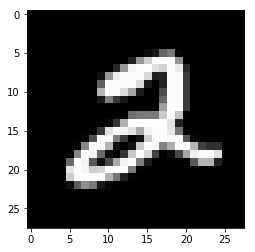

In [ ]:
plt.imshow(clean_data[5,:,:,0], cmap='gray')

In [ ]:
discrim = create_discriminator()
discrim.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0

In [ ]:
gen = create_generator()
gen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              18816     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)      

In [ ]:
gan = create_gan(discrim, gen)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         241537    
_________________________________________________________________
sequential (Sequential)      (None, 1)                 393729    
Total params: 635,266
Trainable params: 241,153
Non-trainable params: 394,113
_________________________________________________________________


In [ ]:
for epoch in range(1, 501):
    d_loss = 0.0
    d_acc = 0.0
    g_loss = 0.0
    for _ in trange(200):
        noise = np.random.normal(0, 1, [128, 2])
        gen_imgs = gen.predict(noise)
        img_batch = clean_data[np.random.randint(low=0, high=clean_data.shape[0], size=128)]
        X = np.concatenate([img_batch, gen_imgs])
        y_dis = np.zeros(2 * 128)
        y_dis[:128] = 1
        
        discrim.trainable = True
        d_train = discrim.train_on_batch(X, y_dis)
        d_loss += d_train[0]
        d_acc += d_train[1]
        
        noise = np.random.normal(0, 1, [128, 2])
        y_gen = np.ones(128)
        
        discrim.trainable = False
        g_loss = g_loss + gan.train_on_batch(noise, y_gen)
        
    print("Epoch %d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_acc/200, g_loss))
    plot_imgs(epoch, gen)


Epoch 1 [D loss: 121.361856, acc: 84.96%] [G loss: 1338.372371]



Epoch 2 [D loss: 74.711259, acc: 89.80%] [G loss: 1251.294044]



Epoch 3 [D loss: 89.232267, acc: 86.65%] [G loss: 1237.458799]



Epoch 4 [D loss: 63.624134, acc: 90.36%] [G loss: 1323.923440]



Epoch 5 [D loss: 72.716423, acc: 88.01%] [G loss: 1357.905909]



Epoch 6 [D loss: 35.661493, acc: 93.52%] [G loss: 949.303273]



Epoch 7 [D loss: 46.810524, acc: 91.37%] [G loss: 914.144269]



Epoch 8 [D loss: 38.385953, acc: 93.43%] [G loss: 1004.222172]



Epoch 9 [D loss: 37.345261, acc: 93.02%] [G loss: 955.133003]



Epoch 10 [D loss: 35.110837, acc: 93.52%] [G loss: 985.561654]



Epoch 11 [D loss: 32.800779, acc: 93.88%] [G loss: 942.202430]



Epoch 12 [D loss: 40.159899, acc: 92.72%] [G loss: 819.119357]



Epoch 13 [D loss: 36.861160, acc: 93.12%] [G loss: 752.905158]



Epoch 14 [D loss: 36.371022, acc: 93.20%] [G loss: 832.459449]



Epoch 15 [D loss: 34.500941, acc: 93.54%] [G loss: 851.132614]



Epoch 16 [D loss: 29.368992, acc: 94.53%] [G loss: 861.659752]



Epoch 17 [D loss: 29.208435, acc: 94.48%] [G loss: 826.248717]



Epoch 18 [D loss: 35.509035, acc: 93.46%] [G loss: 915.426668]



Epoch 19 [D loss: 32.375265, acc: 93.92%] [G loss: 868.106481]



Epoch 20 [D loss: 36.536592, acc: 93.01%] [G loss: 769.608242]



Epoch 21 [D loss: 38.105766, acc: 92.69%] [G loss: 797.962821]



Epoch 22 [D loss: 34.887569, acc: 93.49%] [G loss: 779.617442]



Epoch 23 [D loss: 37.413996, acc: 93.07%] [G loss: 745.672709]



Epoch 24 [D loss: 39.206014, acc: 92.46%] [G loss: 747.172663]



Epoch 25 [D loss: 45.540549, acc: 91.02%] [G loss: 663.314779]



Epoch 26 [D loss: 44.812608, acc: 91.43%] [G loss: 672.901525]



Epoch 27 [D loss: 41.208200, acc: 92.15%] [G loss: 681.643090]



Epoch 28 [D loss: 42.410659, acc: 91.76%] [G loss: 665.280105]



Epoch 29 [D loss: 49.148865, acc: 90.33%] [G loss: 616.213407]



Epoch 30 [D loss: 46.122268, acc: 90.95%] [G loss: 641.010166]



Epoch 31 [D loss: 51.218985, acc: 89.73%] [G loss: 583.966703]



Epoch 32 [D loss: 51.570296, acc: 89.72%] [G loss: 582.857108]



Epoch 33 [D loss: 53.074178, acc: 89.42%] [G loss: 535.899789]



Epoch 34 [D loss: 51.202044, acc: 89.95%] [G loss: 592.351256]



Epoch 35 [D loss: 53.736010, acc: 89.11%] [G loss: 527.407413]



Epoch 36 [D loss: 56.274835, acc: 88.67%] [G loss: 527.284777]



Epoch 37 [D loss: 54.141572, acc: 89.34%] [G loss: 524.138443]



Epoch 38 [D loss: 57.594960, acc: 88.34%] [G loss: 501.219252]



Epoch 39 [D loss: 58.340013, acc: 88.32%] [G loss: 500.765164]



Epoch 40 [D loss: 59.370920, acc: 88.03%] [G loss: 508.516775]



Epoch 41 [D loss: 54.042203, acc: 89.18%] [G loss: 519.513989]



Epoch 42 [D loss: 54.651068, acc: 88.88%] [G loss: 506.632733]



Epoch 43 [D loss: 58.009747, acc: 88.28%] [G loss: 500.970735]



Epoch 44 [D loss: 61.246822, acc: 87.50%] [G loss: 500.778931]



Epoch 45 [D loss: 61.035186, acc: 87.31%] [G loss: 481.439160]



Epoch 46 [D loss: 56.543522, acc: 88.57%] [G loss: 493.715115]



Epoch 47 [D loss: 60.608060, acc: 87.57%] [G loss: 470.161336]



Epoch 48 [D loss: 59.600528, acc: 87.79%] [G loss: 477.860822]



Epoch 49 [D loss: 64.190691, acc: 86.63%] [G loss: 466.288733]



Epoch 50 [D loss: 56.272631, acc: 88.81%] [G loss: 496.843395]



Epoch 51 [D loss: 61.731938, acc: 87.32%] [G loss: 468.393273]



Epoch 52 [D loss: 58.716999, acc: 87.84%] [G loss: 491.226366]



Epoch 53 [D loss: 58.504889, acc: 88.04%] [G loss: 475.014415]



Epoch 54 [D loss: 65.906718, acc: 86.11%] [G loss: 428.791631]



Epoch 55 [D loss: 61.888906, acc: 87.29%] [G loss: 457.052323]



Epoch 56 [D loss: 61.974676, acc: 87.55%] [G loss: 450.296504]



Epoch 57 [D loss: 64.775488, acc: 86.53%] [G loss: 437.473866]



Epoch 58 [D loss: 61.784628, acc: 87.40%] [G loss: 430.281115]



Epoch 59 [D loss: 61.418833, acc: 87.22%] [G loss: 457.164383]



Epoch 60 [D loss: 61.570550, acc: 87.47%] [G loss: 457.021808]



Epoch 61 [D loss: 57.441849, acc: 88.55%] [G loss: 476.902679]



Epoch 62 [D loss: 59.701764, acc: 88.15%] [G loss: 441.227396]



Epoch 63 [D loss: 60.360572, acc: 88.11%] [G loss: 435.514566]



Epoch 64 [D loss: 60.327161, acc: 87.37%] [G loss: 434.382292]



Epoch 65 [D loss: 66.815183, acc: 85.91%] [G loss: 433.575623]



Epoch 66 [D loss: 65.712420, acc: 86.14%] [G loss: 426.903688]



Epoch 67 [D loss: 64.535841, acc: 86.31%] [G loss: 423.536159]



Epoch 68 [D loss: 62.000296, acc: 87.22%] [G loss: 433.257158]



Epoch 69 [D loss: 61.665824, acc: 87.00%] [G loss: 425.477664]



Epoch 70 [D loss: 61.818710, acc: 87.25%] [G loss: 438.007951]



Epoch 71 [D loss: 62.406613, acc: 87.03%] [G loss: 434.381168]



Epoch 72 [D loss: 61.102380, acc: 87.43%] [G loss: 457.001468]



Epoch 73 [D loss: 55.826080, acc: 88.99%] [G loss: 467.921589]



Epoch 74 [D loss: 57.352582, acc: 88.65%] [G loss: 466.955941]



Epoch 75 [D loss: 59.877506, acc: 87.86%] [G loss: 443.062198]



Epoch 76 [D loss: 57.516873, acc: 88.49%] [G loss: 479.884068]



Epoch 77 [D loss: 61.482113, acc: 87.44%] [G loss: 437.012113]



Epoch 78 [D loss: 60.010374, acc: 87.98%] [G loss: 452.726899]



Epoch 79 [D loss: 64.481929, acc: 86.62%] [G loss: 433.355719]



Epoch 80 [D loss: 60.471209, acc: 87.55%] [G loss: 442.277971]



Epoch 81 [D loss: 62.169502, acc: 87.08%] [G loss: 438.799515]



Epoch 82 [D loss: 61.734154, acc: 87.29%] [G loss: 438.059750]



Epoch 83 [D loss: 64.464205, acc: 86.61%] [G loss: 426.520160]



Epoch 84 [D loss: 62.090481, acc: 87.07%] [G loss: 410.314785]



Epoch 85 [D loss: 60.777973, acc: 87.54%] [G loss: 452.066406]



Epoch 86 [D loss: 57.505271, acc: 88.37%] [G loss: 457.411971]



Epoch 87 [D loss: 66.512578, acc: 85.96%] [G loss: 418.556116]



Epoch 88 [D loss: 65.684593, acc: 86.18%] [G loss: 409.396817]



Epoch 89 [D loss: 59.742298, acc: 87.98%] [G loss: 470.252238]



Epoch 90 [D loss: 65.432382, acc: 86.21%] [G loss: 418.418692]



Epoch 91 [D loss: 65.851633, acc: 86.11%] [G loss: 400.252728]



Epoch 92 [D loss: 62.097800, acc: 87.02%] [G loss: 418.753546]



Epoch 93 [D loss: 62.731636, acc: 86.83%] [G loss: 447.703972]



Epoch 94 [D loss: 68.875852, acc: 85.36%] [G loss: 392.437275]



Epoch 95 [D loss: 64.624861, acc: 86.56%] [G loss: 409.531933]



Epoch 96 [D loss: 64.438816, acc: 86.82%] [G loss: 422.892653]



Epoch 97 [D loss: 68.222627, acc: 85.26%] [G loss: 393.549344]



Epoch 98 [D loss: 70.785140, acc: 84.61%] [G loss: 405.852080]



Epoch 99 [D loss: 73.047851, acc: 83.94%] [G loss: 381.049922]



Epoch 100 [D loss: 70.249950, acc: 84.93%] [G loss: 393.439976]



Epoch 101 [D loss: 69.671664, acc: 85.04%] [G loss: 384.488555]



Epoch 102 [D loss: 68.065529, acc: 85.44%] [G loss: 410.952447]



Epoch 103 [D loss: 65.925298, acc: 86.40%] [G loss: 418.664111]



Epoch 104 [D loss: 67.880040, acc: 85.63%] [G loss: 406.930580]



Epoch 105 [D loss: 70.454039, acc: 84.86%] [G loss: 401.378819]



Epoch 106 [D loss: 67.076080, acc: 85.62%] [G loss: 394.911739]



Epoch 107 [D loss: 69.996585, acc: 85.02%] [G loss: 395.684105]



Epoch 108 [D loss: 71.072759, acc: 84.71%] [G loss: 389.071798]



Epoch 109 [D loss: 69.674608, acc: 85.04%] [G loss: 399.144725]



Epoch 110 [D loss: 71.212211, acc: 84.51%] [G loss: 385.944920]



Epoch 111 [D loss: 72.707123, acc: 84.07%] [G loss: 389.160411]



Epoch 112 [D loss: 75.046346, acc: 83.60%] [G loss: 383.701932]



Epoch 113 [D loss: 72.833266, acc: 84.02%] [G loss: 375.954362]



Epoch 114 [D loss: 73.324452, acc: 84.00%] [G loss: 383.180736]



Epoch 115 [D loss: 74.030219, acc: 83.81%] [G loss: 366.492902]



Epoch 116 [D loss: 74.180618, acc: 83.92%] [G loss: 388.356307]



Epoch 117 [D loss: 72.981890, acc: 83.88%] [G loss: 373.416989]



Epoch 118 [D loss: 73.534696, acc: 83.95%] [G loss: 371.558382]



Epoch 119 [D loss: 73.832771, acc: 83.92%] [G loss: 371.219378]



Epoch 120 [D loss: 73.095321, acc: 84.09%] [G loss: 381.632386]



Epoch 121 [D loss: 74.146390, acc: 83.80%] [G loss: 367.882331]



Epoch 122 [D loss: 72.416240, acc: 84.14%] [G loss: 376.654616]



Epoch 123 [D loss: 78.231664, acc: 82.51%] [G loss: 362.711384]



Epoch 124 [D loss: 75.105105, acc: 83.36%] [G loss: 358.485339]



Epoch 125 [D loss: 74.088301, acc: 83.88%] [G loss: 374.066017]



Epoch 126 [D loss: 74.467821, acc: 83.57%] [G loss: 372.036219]



Epoch 127 [D loss: 73.728904, acc: 83.66%] [G loss: 367.661894]



Epoch 128 [D loss: 74.949539, acc: 83.33%] [G loss: 377.803094]



Epoch 129 [D loss: 74.103245, acc: 83.92%] [G loss: 374.399425]



Epoch 130 [D loss: 73.726057, acc: 83.87%] [G loss: 363.645971]



Epoch 131 [D loss: 73.627103, acc: 83.70%] [G loss: 379.322118]



Epoch 132 [D loss: 73.733070, acc: 83.57%] [G loss: 369.451447]



Epoch 133 [D loss: 76.543333, acc: 83.16%] [G loss: 369.705655]



Epoch 134 [D loss: 75.761841, acc: 83.16%] [G loss: 358.124187]



Epoch 135 [D loss: 75.690712, acc: 83.07%] [G loss: 366.884367]



Epoch 136 [D loss: 75.954750, acc: 83.49%] [G loss: 361.337144]



Epoch 137 [D loss: 73.721759, acc: 83.83%] [G loss: 361.658421]



Epoch 138 [D loss: 75.955000, acc: 83.18%] [G loss: 357.419213]



Epoch 139 [D loss: 77.068364, acc: 82.78%] [G loss: 365.870094]



Epoch 140 [D loss: 76.935543, acc: 82.83%] [G loss: 353.175956]



Epoch 141 [D loss: 74.701669, acc: 83.18%] [G loss: 373.858817]



Epoch 142 [D loss: 76.068157, acc: 83.12%] [G loss: 361.232058]



Epoch 143 [D loss: 78.066209, acc: 82.58%] [G loss: 353.558750]



Epoch 144 [D loss: 78.148489, acc: 82.39%] [G loss: 357.953809]



Epoch 145 [D loss: 80.131069, acc: 82.07%] [G loss: 341.904043]



Epoch 146 [D loss: 76.952145, acc: 82.56%] [G loss: 342.822370]



Epoch 147 [D loss: 79.389008, acc: 81.85%] [G loss: 354.359188]



Epoch 148 [D loss: 80.976634, acc: 81.87%] [G loss: 332.521737]



Epoch 149 [D loss: 80.755254, acc: 81.70%] [G loss: 351.671121]



Epoch 150 [D loss: 80.036003, acc: 81.82%] [G loss: 342.529805]



Epoch 151 [D loss: 80.601136, acc: 81.66%] [G loss: 339.594515]



Epoch 152 [D loss: 75.785863, acc: 83.28%] [G loss: 372.754322]



Epoch 153 [D loss: 82.744636, acc: 81.31%] [G loss: 334.242241]



Epoch 154 [D loss: 80.863485, acc: 81.58%] [G loss: 336.455835]



Epoch 155 [D loss: 80.648434, acc: 81.84%] [G loss: 356.672030]



Epoch 156 [D loss: 77.311078, acc: 82.71%] [G loss: 350.745740]



Epoch 157 [D loss: 79.503063, acc: 82.21%] [G loss: 357.059517]



Epoch 158 [D loss: 80.646392, acc: 81.68%] [G loss: 345.345984]



Epoch 159 [D loss: 78.569490, acc: 82.13%] [G loss: 350.753567]



Epoch 160 [D loss: 75.032170, acc: 83.42%] [G loss: 363.638994]



Epoch 161 [D loss: 77.982439, acc: 82.61%] [G loss: 352.357512]



Epoch 162 [D loss: 77.423418, acc: 82.88%] [G loss: 359.933824]



Epoch 163 [D loss: 79.572915, acc: 82.11%] [G loss: 351.957124]



Epoch 164 [D loss: 77.641191, acc: 82.52%] [G loss: 361.993150]



Epoch 165 [D loss: 78.608790, acc: 82.30%] [G loss: 352.400000]



Epoch 166 [D loss: 76.397216, acc: 82.90%] [G loss: 365.202544]



Epoch 167 [D loss: 81.181598, acc: 81.55%] [G loss: 341.215301]



Epoch 168 [D loss: 76.036756, acc: 83.17%] [G loss: 374.851849]



Epoch 169 [D loss: 80.445610, acc: 82.08%] [G loss: 358.092524]



Epoch 170 [D loss: 76.771670, acc: 82.81%] [G loss: 362.932542]



Epoch 171 [D loss: 79.367812, acc: 82.38%] [G loss: 346.311499]



Epoch 172 [D loss: 79.089686, acc: 82.25%] [G loss: 343.796817]



Epoch 173 [D loss: 80.120090, acc: 82.05%] [G loss: 337.672237]



Epoch 174 [D loss: 79.071895, acc: 82.23%] [G loss: 347.717408]



Epoch 175 [D loss: 80.579602, acc: 81.81%] [G loss: 346.206223]



Epoch 176 [D loss: 80.007142, acc: 81.94%] [G loss: 351.565217]



Epoch 177 [D loss: 78.426461, acc: 82.48%] [G loss: 345.343595]



Epoch 178 [D loss: 79.438573, acc: 82.11%] [G loss: 345.909720]



Epoch 179 [D loss: 80.225000, acc: 81.80%] [G loss: 353.642588]



Epoch 180 [D loss: 84.320205, acc: 80.62%] [G loss: 333.425275]


In [ ]:
gen.save('../mnist_models/gen_500_epochs.h5')
discrim.save('../mnist_models/discrim_500_epochs.h5')
gan.save('../mnist_models/gan_500_epochs.h5')